In [245]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative#, Param_dirich
plt.style.use('cyberpunk')

### The observational data

In [246]:
datosH=np.loadtxt('datosH.txt')
datosH = torch.Tensor(datosH)
z=datosH[:,0].view(-1,1)
H=datosH[:,1].view(-1,1)

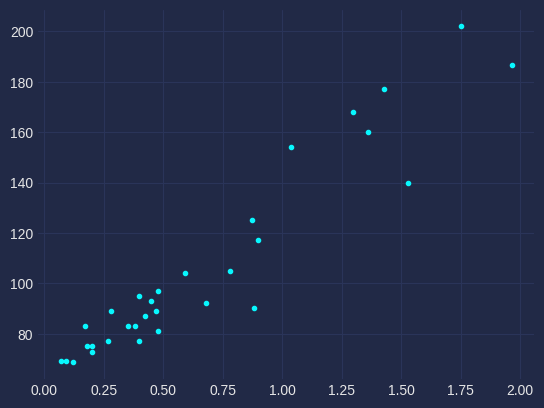

In [247]:
plt.plot(z,H,'.');

In [248]:
#Training and validation datasets
a,b = torch.utils.data.random_split(z, [20, 11])
a,b = torch.tensor(a), torch.tensor(b)

# Encontrar las posiciones donde los elementos de a coinciden con z
idx_train = torch.where(z == a)
idx_val = torch.where(z == b)
# Convertir el tensor de índices a una lista
idx_train = idx_train[0].tolist()
idx_val = idx_val[0].tolist()

# Dividir el conjunto H usando los índices
z_train, H_train=z[idx_train], H[idx_train]
z_val, H_val = z[idx_val], H[idx_val]

In [249]:
#Neural network architecture

nodos=30
ANN = nn.Sequential(nn.Linear(1, nodos),# nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=30, bias=True)
  (1): Tanh()
  (2): Linear(in_features=30, out_features=1, bias=True)
)


In [250]:
def cost(t, Y):
    t.requires_grad=True
    osc = ANN(t) - Y
    #t0=torch.tensor([zi], requires_grad=True)

    # x0=T[:,1].view(-1,1)
    # t0=torch.zeros_like(x0, requires_grad=True)
    # t0 = torch.concat((t0,x0),1)
    # condi = ANN(t0) - x0

    return 1.0/32.0 * torch.mean(osc**2)

In [251]:
cost(z, Y=H)

tensor(398.0441, grad_fn=<MulBackward0>)

In [252]:
#4 Error and optimizer
learning_rate=0.01
epocas=2500

optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)

Training: 100%|█████████████████████████████████████| 2500/2500 [00:06<00:00, 358.66it/s, loss=3.09]


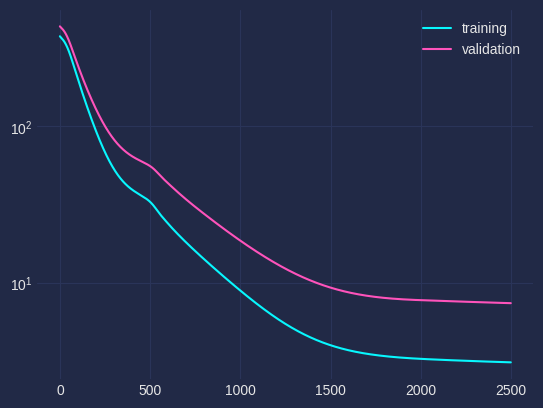

In [253]:
#training loop
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

err_train=[]
err_val=[]
for i in pbar:
    l=cost(z_train, Y=H_train) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    err_train.append(float(l))
    err_val.append(float(cost(z_val, Y=H_val)))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),err_train, label='training')
plt.plot(range(epocas),err_val, label='validation')
plt.legend()
plt.yscale('log')

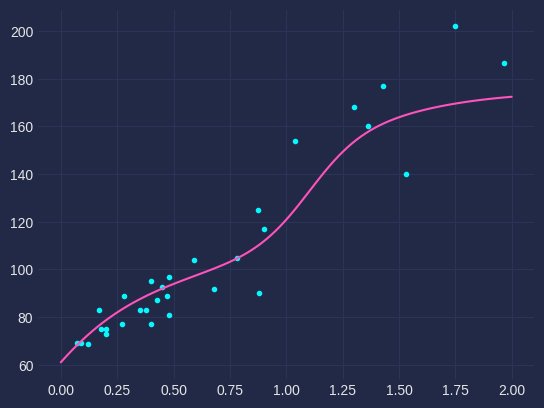

In [257]:
z0= torch.linspace(0,2,100).view(-1,1)
plt.plot(z.detach().numpy(),H,'.')
plt.plot(z0, ANN(z0).detach().numpy())

In [258]:
torch.save(ANN.state_dict(),'friedmann')